# Variational Autoencoder
- refers to variational inference
- extension of expectation-maximization
- output of encoder is a guassian, output of decoder is a bernoulli
- then turn output to bayesian --> p(x_reconstructed | x ~ bernoulli(p)) 
- then generate samples from that distribution

#### Parameterize a gaussian
- https://sefiks.com/2017/08/11/softplus-as-a-neural-networks-activation-function/
- approximates p(z|x), the true conditional distribution, as q(z|x)

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
import time
from scipy.stats import multivariate_normal as mvn

In [3]:
def softplus(x):
    # automatically adds 1 
    return np.log1p(np.exp(x))

In [4]:
def forward(x, W1, W2):
    hidden = np.tanh(x.dot(W1))
    output = hidden.dot(W2) # no activation
    mean   = output[:2]
    std    = softplus(output[2:])
    return mean, std

In [5]:
def get_mnist(file,limit=None):
    df = pd.read_csv('datasets/mnist_train_kaggle.csv')
    data = df.values
    # np.random.shuffle(data)
    X = data[:, 1:] / 255.0 # data is from 0..255
    Y = data[:, 0]
    X, Y = shuffle(X, Y)
    if limit is not None:
        X, Y = X[:limit], Y[:limit]
    return X, Y

Make a random input and generate some samples

In [6]:
input_ = 4
hidden = 3
output = 2
W1 = np.random.randn(input_, hidden)
# multiply by 2 for mean and std (2 params!)
W2 = np.random.randn(hidden, output*2)

x = np.random.randn(input_)

mean, std = forward(x, W1, W2)
print("mean: {}, std: {}".format(mean, std))

samples = mvn.rvs(mean=mean, cov=std**2, size=10000)

mean: [0.84138073 0.90905135], std: [1.22372347 0.09681592]


plot the samples

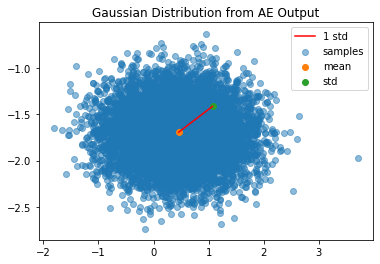

In [16]:
plt.scatter(samples[:,0], samples[:,1], alpha=.5, label='samples')
plt.scatter(mean[0], mean[1], label='mean')
plt.scatter(mean[0]+std[0], mean[1]+std[1], label='std')
plt.plot([mean[0], mean[0]+std[0]], [mean[1], mean[1]+std[1]], 'r', label='1 std')
plt.legend()
plt.title("Gaussian Distribution from AE Output")
plt.show()

#### Variational Inference
Evidence Lower Bound (in variational inference)
- http://users.umiacs.umd.edu/~xyang35/files/understanding-variational-lower.pdf
- https://www.cs.princeton.edu/courses/archive/fall11/cos597C/lectures/variational-inference-i.pdf
- https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence
- E[log p(x|z)] - KLD[q(z|x)||p(z)]
- expected log-likelihood minus KL divergence of posterior and prior (higher KLD -> higher difference)
- ELL tells us how close we are to the target, KLD is regularization penalty

### The Variational Autoencoder

In [37]:
class DenseLayer(object):
    def __init__(self, dim_data, dim_layer, activation=tf.nn.relu):
        self.W = tf.Variable(tf.random_normal(shape=(dim_data, dim_layer))*2/np.sqrt(dim_data))
        self.b = tf.Variable(np.zeros(dim_layer).astype(np.float32))
        self.activation = activation
        
    def forward(self, X):
        return self.activation(tf.matmul(X, self.W) + self.b)

class VariationalAutoencoder(object):
    def __init__(self, D, H):
        """
            Descr: initializes the encoder
            
            Params:
                D: input layer dimension
                H: hidden layer sizes up to layer Z
        """
        self.X = tf.placeholder(tf.float32, shape=(None, D))
        
        # encoder
        self.encoderLayers = []
        layer_in = D
        for layer_out in H[:-1]:
            layer = DenseLayer(layer_in, layer_out)
            self.encoderLayers.append(layer)
            layer_in = layer_out
            
        # the final encoder layer
        layer = DenseLayer(layer_in, 2*H[-1], activation=lambda x: x)
        self.encoderLayers.append(layer)
        
        currentLayer = self.X
        for layer in self.encoderLayers:
            currentLayer = layer.forward(currentLayer)
            self.means = currentLayer[:, :H[-1]]
            self.std = tf.nn.softplus(currentLayer[:, H[-1]:]) + 1e-6
            
        standardNormal = tf.contrib.distributions.Normal(loc=np.zeros(H[-1], dtype=np.float32), scale=np.ones(H[-1], dtype=np.float32))
        eps = standardNormal.sample(tf.shape(self.means)[0])
        self.Z = eps * self.std + self.means
        
        # decoder
        self.decoderLayers = []
        layer_in = H[-1]
        for layer_out in reversed(H[:-1]):
            layer = DenseLayer(layer_in, layer_out)
            self.decoderLayers.append(layer)
            layer_in = layer_out
            
        # final decoder layer
        layer = DenseLayer(layer_in, D, activation=lambda x: x)
        self.decoderLayers.append(layer)
        
        # logits
        currentLayer = self.Z
        for layer in self.decoderLayers:
            currentLayer = layer.forward(currentLayer)
        logits = currentLayer
        posteriorLogits = logits
        
        # the output (a distribution)
        self.X_hat = tf.contrib.distributions.Bernoulli(logits=logits)
        
        # sampling
        self.posteriorPred = self.X_hat.sample()
        self.posteriorProb = tf.nn.sigmoid(logits)
        
        z_std = standardNormal.sample(1)
        currentLayer = z_std
        for layer in self.decoderLayers:
            currentLayer = layer.forward(currentLayer)
        logits = currentLayer
        
        priorDist = tf.contrib.distributions.Bernoulli(logits=logits)
        self.priorPred = priorDist.sample()
        self.priorProb = tf.nn.sigmoid(logits)
        
        self.z_in = tf.placeholder(tf.float32, shape=(None, H[-1]))
        currentLayer = self.z_in
        for layer in self.decoderLayers:
            currentLayer = layer.forward(currentLayer)
            logits = currentLayer
        self.priorFromInput = tf.nn.sigmoid(logits)
        
        # cost 
        KL = -tf.log(self.std) + .5*(self.std**2 + self.means**2) -.5
        KL = tf.reduce_sum(KL, axis=1)
        ELL = tf.reduce_sum(self.X_hat.log_prob(self.X), 1)
        
        self.elbo = tf.reduce_sum(ELL - KL)
        self.train_op = tf.train.RMSPropOptimizer(learning_rate=.001).minimize(-self.elbo)
        
        # session
        self.init_op = tf.global_variables_initializer()
        self.sess = tf.InteractiveSession()
        self.sess.run(self.init_op)
        
    def fit(self, X, epochs=40, batch_size=64, verbose=False):
        costs = []
        n_batches = len(X) // batch_size
        if(verbose):
            print("number of batches: " + str(n_batches))
        for i in range(epochs):
            if(verbose):
                print("epoch: " + str(i))
            np.random.shuffle(X)
            for j in range(n_batches):
                start = j*batch_size
                stop  = (j+1)*batch_size
                batch = X[start:stop]
                _, c, = self.sess.run((self.train_op, self.elbo), feed_dict={self.X: batch})
                c /= batch_size
                costs.append(c)
                if(verbose):
                    if(j % 100 == 0):
                        print("iteration: %d, cost: %.3f" % (j,c))
        return costs
    
    def transform(self, X):
        return self.sess.run(self.means, feed_dict={self.X: X})
        
    def priorWithInput(self, Z):
        return self.sess.run(self.priorFromInput, feed_dict={self.z_in: Z})
    
    def posteriorSample(self, X):
        return self.sess.run(self.posteriorPred, feed_dict={self.X: X})

    def priorSample(self):
        return self.sess.run((self.priorPred, self.priorProb))
        

In [52]:
X, y = get_mnist('datasets/mnist_train_kaggle.csv')

In [53]:
with tf.device('/gpu:1'):
    vae = VariationalAutoencoder(784, [200, 100])
    start = time.time()
    cost = vae.fit(X)
    end = time.time()
    print("took %.2f seconds to fit" % (end-start))
    


took 63.64 seconds to fit


#### Demonstrate Reconstruction
- reconstruction is generally worse than the original due to Bernoulli sampling!

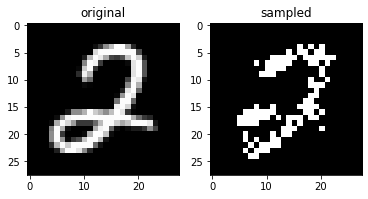

In [61]:
i = np.random.choice(len(X))
x = X[i]
img = vae.posteriorSample([x]).reshape(28,28)
plt.subplot(121)
plt.imshow(x.reshape(28,28), cmap='gray')
plt.title("original")
plt.subplot(122)
plt.imshow(img, cmap='gray')
plt.title("sampled")
plt.show()

#### Demonstrate sampling from latent space

Text(0.5, 1.0, 'prior predictive probability')

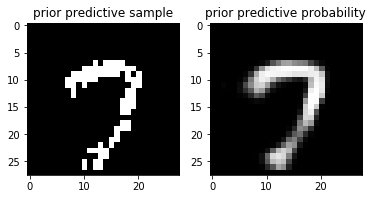

In [75]:
img, prob = vae.priorSample()
img = img.reshape(28,28)
prob = prob.reshape(28,28)
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.title("prior predictive sample")
plt.subplot(122)
plt.imshow(prob, cmap='gray')
plt.title("prior predictive probability")

In [76]:
vae.sess.close()

### What does the latent space represent?
- lets reduce the dimensionality of the latent space to 2 so we can see on a grid

In [77]:
with tf.device('/gpu:1'):
    vae = VariationalAutoencoder(784, [200, 100, 2])
    start = time.time()
    vae.fit(X)
    end = time.time()
    print("took %.2f seconds to fit" % (end-start))

took 68.52 seconds to fit


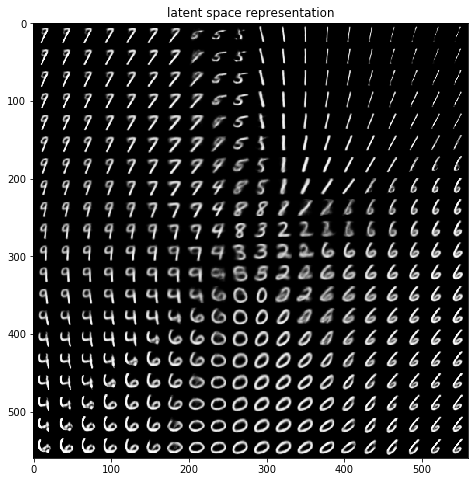

In [85]:
n = 20
xvals = np.linspace(-3, 3, n)
yvals = np.linspace(-3, 3, n)
image = np.empty((28*n, 28*n))

Z = []
for i, x in enumerate(xvals):
    for j, y in enumerate(yvals):
        z = [x,y]
        Z.append(z)

x_reconstructed = vae.priorWithInput(Z)

k = 0
for i, x in enumerate(xvals):
    for j, y in enumerate(yvals):
        xre = x_reconstructed[k]
        k = k + 1
        xre = xre.reshape(28,28)
        x1 = (n-i-1)*28
        x2 = (n-i)*28
        y1 = j*28
        y2 = (j+1)*28
        image[x1:x2, y1:y2] = xre
plt.figure(figsize=(8,8))  
plt.imshow(image, cmap='gray')
plt.title("latent space representation")
plt.show()

In [86]:
vae.sess.close()